# Backtesting tool

[*********************100%***********************]  1 of 1 completed


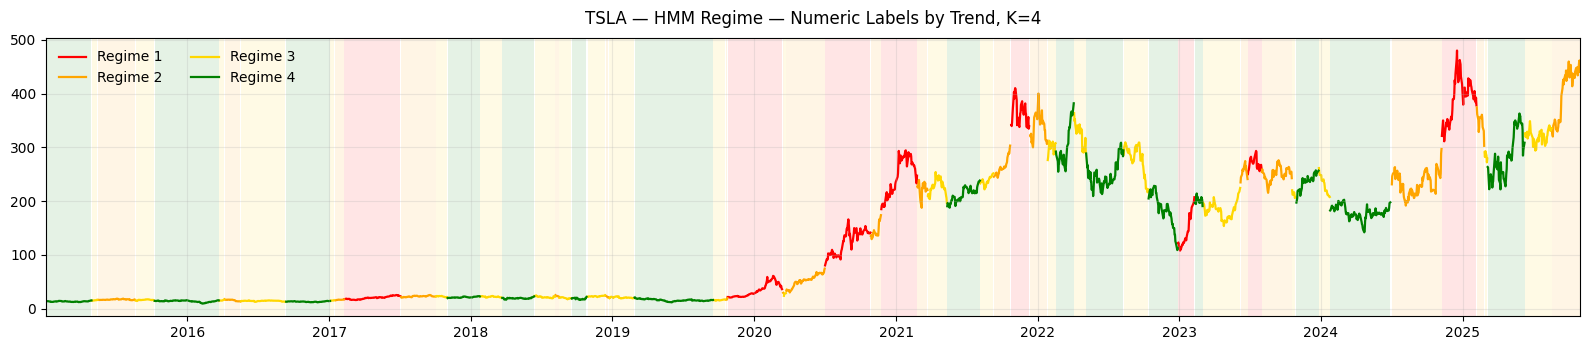


--- HMM Results (K=4) ---
Features Used: ['Level_ATR100', 'RSI']
Best log-likelihood: -4671.097729911129
   state  trend_score  mom_score  macd_score  ac1_5_score
0      1    34.175576   0.005962    0.018818          NaN
1      3    16.353685   0.010116   -0.052953          NaN
2      2     1.010016   0.939173   -0.369444          NaN
3      0   -13.016806  -0.046535    0.349432          NaN


In [168]:
from hmm_regime import HMMRegimeAnalyzer, with_regime_index

analyzer = HMMRegimeAnalyzer(
    ticker="TSLA",
    start="2010-01-01",
    plot_start="2015-01-01",
    n_states=4,
    n_trials=20,
    ma_window=120,
    rsi_period=14,
    ac_window=60,
    smoothing_window_mr=1,
    use_slope=False,
    use_ac=False,
    use_rsi=True,
    use_volume=False
)

df, feats_scaled, model, mapping = analyzer.run()
df_ix = with_regime_index(df)


In [169]:
import pandas as pd
import yfinance as yf

ticker = analyzer.ticker
start  = analyzer.start

# 1) 원시 다운로드 (멀티인덱스까지 고려)
raw = yf.download(ticker, start=start, auto_adjust=True, progress=False)

def _get_ohl_from_yf(df):
    """
    yfinance 단일 티커에서 생기는 케이스 모두 처리해서
    Open/High/Low 각각 1D Series로 리턴.
    """
    def _extract(field: str) -> pd.Series:
        if isinstance(df.columns, pd.MultiIndex):
            lvl0 = df.columns.get_level_values(0)
            lvl1 = df.columns.get_level_values(1)
            # case A: 레벨1에 필드명이 있는 경우
            if field in set(lvl1):
                s = df.xs(field, level=1, axis=1)
            # case B: 레벨0에 필드명이 있는 경우
            elif field in set(lvl0):
                s = df[field]
            else:
                raise KeyError(f"Cannot locate {field} in columns {df.columns}")
            # 단일 티커면 DF일 수 있으니 1D로 납작화
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
        else:
            s = df[field]
        return pd.to_numeric(s, errors='coerce').rename(field)

    O = _extract('Open')
    H = _extract('High')
    L = _extract('Low')
    return O, H, L

open_, high, low = _get_ohl_from_yf(raw)

# 2) df와 정렬 맞추고 결합 (df는 기존에 가지고 있던 가격/레짐 DF)
ohl = pd.concat([open_, high, low], axis=1).reindex(df.index)
df_aug = df.join(ohl)

# 3) 표준 컬럼명 보장 + 정렬
df_aug = df_aug.rename(columns={
    'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'Regime':'regime'
})
df_aug = df_aug[~df_aug.index.duplicated(keep='last')].sort_index()

# 4) 멀티인덱스 df_ix, 백테스트용 df_out 생성
df_ix = with_regime_index(df_aug)

df_out = (
    df_aug[['Close','Open','High','Low','regime']]
      .dropna(subset=['Close','Open','High','Low','regime'])
      .assign(regime=lambda x: x['regime'].astype(int))
      .sort_index()
)


In [170]:
df_out

,Close,Open,High,Low,regime
Date,,,,,
2010-08-24,1.280000,1.283333,1.314000,1.263333,3
2010-08-25,1.326667,1.277333,1.332000,1.237333,3
2010-08-26,1.316667,1.326000,1.351333,1.306667,3
2010-08-27,1.313333,1.316667,1.324667,1.300000,3
2010-08-30,1.324667,1.313333,1.346000,1.307333,3
...,...,...,...,...,...
2025-10-24,433.720001,446.829987,451.679993,430.170013,2
2025-10-27,452.420013,439.980011,460.160004,438.690002,2
2025-10-28,460.549988,454.779999,467.000000,451.600006,2


In [171]:
import importlib, regime_backtester
importlib.reload(regime_backtester)
from regime_backtester import RegimeBacktester, BTConfig, strategy_attribution

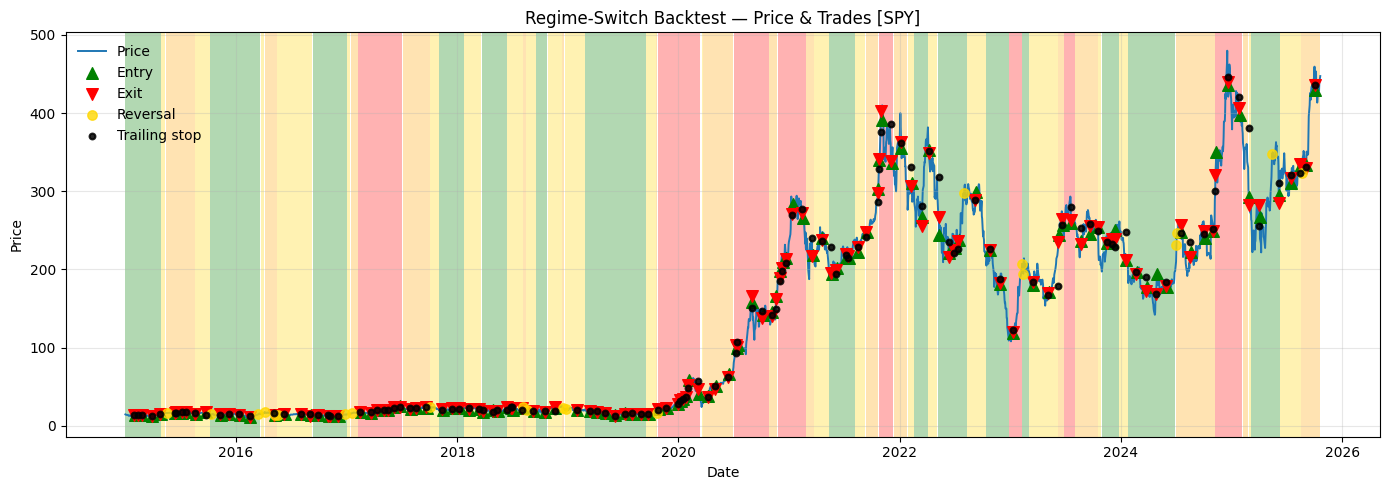

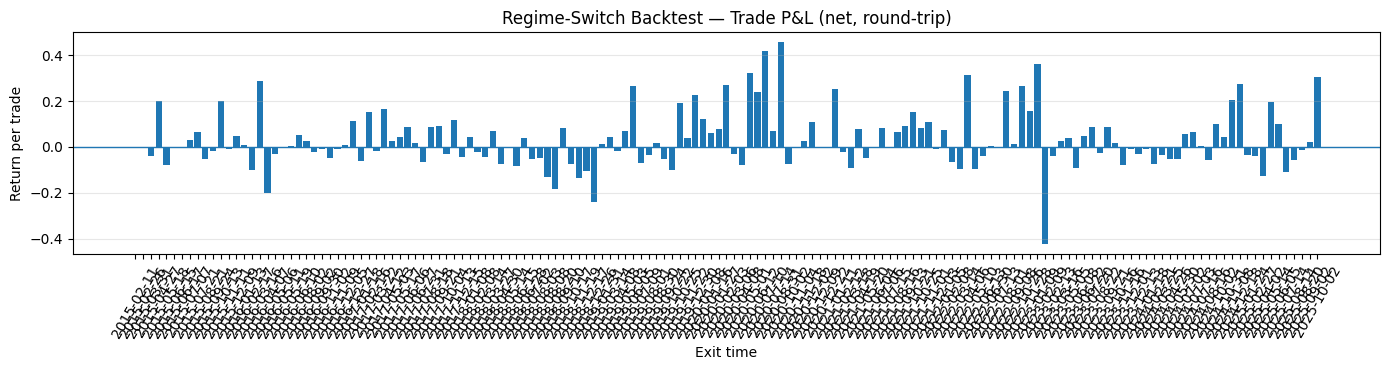

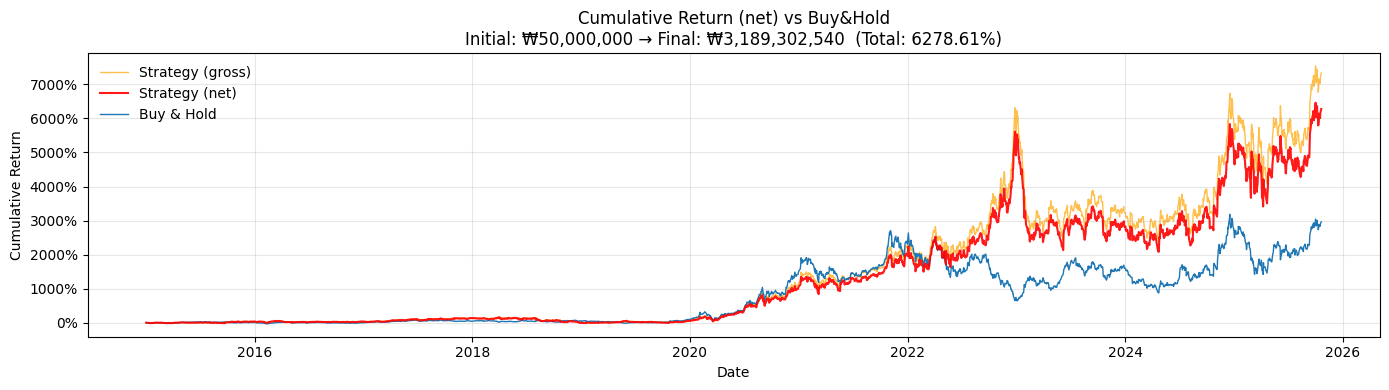

In [172]:
from regime_backtester import RegimeBacktester, BTConfig, strategy_attribution

cfg = BTConfig(init_capital=50_000_000, fee_bps=5, slip_bps=0, allow_shorts=True)
rb  = RegimeBacktester(config=cfg)

strategies = {
    1: RegimeBacktester.strat_momentum,
    2: RegimeBacktester.strat_momentum,
    3: RegimeBacktester.strat_mean_reversion,
    4: RegimeBacktester.strat_mean_reversion,
}

bt = rb.run_backtest(
    df_out,
    strategies = strategies,
    price_col="Close",
    regime_col="regime",
    start="2015-01-01", end="2025-10-20",
    warmup_bars=200,
    exec_shift=1,
    k_atr=2,                        # High/Low가 있으면 ATR 스톱 사용
    trail_pct=None,                   # (있어도 ATR 경로가 우선됩니다)
    execute_on_trigger_close=True,    # 트리거 ‘당일’ 처리 여부
    execute_price_mode="stop",        # 손절 기준값 설정
    min_gain_to_trail_atr=0.2,
    arm_after_bars=21,
    initial_k_atr=2.0,
    hard_stop_use_entry_atr=True,
)

rb.plot_backtest_with_trades_rainbow(bt, df_out, ticker="SPY")
rb.plot_cum_return_after(bt, title="Cumulative Return (net) vs Buy&Hold")


In [136]:
# 1) 이름 자동 생성: regime1_momentum, regime3_mean_reversion ...
name_map = RegimeBacktester.make_regime_name_map(strategies)

# 2) 기여도 표/시리즈
summary, parts = rb.strategy_attribution(
    bt_close, df_out,
    regime_col="regime",
    strategies=strategies,
    name_map=name_map,
)

summary

,TotalRet,CAGR,Sharpe(ann.),MaxDD,DaysActive,Contribution(%)
Strategy,,,,,,
regime1_momentum,2.180669,0.113109,1.946874,-0.043455,874.0,348.108312
regime4_mean_reversion,0.041473,0.003770,0.097101,-0.352064,603.0,6.620557
regime3_mean_reversion,0.030127,0.002753,0.074412,-0.248396,734.0,4.809277
regime2_momentum,-0.522972,-0.066251,-0.921388,-0.557158,504.0,-83.483956
__TOTAL__,0.626434,0.046155,0.340675,-0.341499,2715.0,100.000000
